In [159]:
################################
# LIBRARIES
################################
from src.util import *
from src.frames import *

from matplotlib import dates
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import os

# Matplotlib settings
plt.style.use("seaborn")

params = {
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "axes.labelsize": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "text.usetex": False,
    "figure.figsize": [10, 5],
    "axes.grid": True,
}

plt.rcParams.update(params)
plt.close("all")

# Apply the default theme
sns.set_theme()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [133]:
################################
# FUNCTIONS
################################

def get_timestamp(timestr, date, offset=0):
    return datetime.strptime(f'{date} {timestr}', '%Y-%m-%d %H:%M:%S') + timedelta(seconds=offset)

def add_secs(initial, secs):
    return initial + timedelta(seconds=secs)

def format_time(date, time_int):
    # convert int to str
    str_time = str(time_int)
    
    # Pad 5:00:00 to 05:00:00
    if len(str_time) < 6:
        str_time = '0' + str_time
    
    # Concatenate date and time
    str_time = date + ' ' + str_time
    
    # Convert string into date time object
    result = datetime.strptime(str_time, '%Y-%m-%d %H%M%S')
    
    return result

In [135]:
def plot_disc(disc_df, start_stop, title, figname=False):
    # Plot
    fig, ax = plt.subplots(dpi=200, figsize=[10,5])

    colors = ['k', 'm', 'b', 'g', 'c', 'y', 'darkorange', 'seagreen', 'royalblue', 'lightcoral', 'sandybrown', 'powderblue', 'violet', 'lawngreen', 'firebrick', 'khaki', 'darkmagenta']
    ax.plot(disc_df['Timestamp'], disc_df['Number'], label='Disc Mini')

    i = 0
    for station, row in start_stop.iterrows():
        start = row['Timestamp']['min']
        stop = row['Timestamp']['max']
        
        if i >= len(colors):
            i = 0
            
        ax.axvline(start, c=colors[i])
        ax.axvline(stop, c=colors[i])

        ax.text(start, disc_df['Number'].max() / 2, station, fontsize=8, rotation=90)

        i+=1

    # Label axis
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Time')
    ax.set_ylabel('PM2.5 Count')

    # Format time on x-axis
    plt.gcf().autofmt_xdate()
    myFmt = dates.DateFormatter('%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    if figname:
        plt.savefig(figname)

    plt.show()

In [136]:
def get_disc_chunk(s_id, start_stop, disc_df):
    # Extract timestamps for disc record
    station_chunks = []

    for station, row in start_stop.iterrows():
        start = row['Timestamp']['min']
        stop = row['Timestamp']['max']

        chunk = disc_df[(disc_df['Timestamp'] >= start) & (disc_df['Timestamp'] <= stop)]

        # Add date and station and sensor columns
        chunk['Station'] = station
        chunk['Date'] = date
        chunk['Sensor'] = 'DiSC'

        # Remove old index column
        chunk.reset_index(drop=True, inplace=True)

        station_chunks.append(chunk)

    session_chunk = pd.concat(station_chunks)
    session_chunk.reset_index(drop=True, inplace=True)
    session_chunk['Session Id'] = s_id
    
    return session_chunk

In [137]:
def create_folders(folders):
    for folder_name in folders:
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

### CLEAN DISC TIMESTAMP

In [214]:
def fix_timestamp(x):
    if str(x).endswith('.500'):
        return datetime.strptime(str(x)[:-4], '%Y-%m-%d %H:%M:%S') 
    else:
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S') 

main_folder = 'sessionsDiSC'

folders = get_folder_paths(main_folder)

for folder in folders:
    # Get session files in folder
    session_files = [f for f in os.listdir(folder) if f.endswith(".csv")]
    
    # Some session files must be found to proceed
    if len(session_files) <= 0:
        continue
        
    # Go through every session file
    for s_file in session_files:
        # Load session
        raw_session_df = pd.read_csv(folder + "/" + s_file)
        raw_session_df = raw_session_df.loc[:, ~raw_session_df.columns.str.contains('^Unnamed')]
        
        # Fix timestamp column
        raw_session_df['Timestamp'] = raw_session_df['Timestamp'].apply(lambda x: fix_timestamp(x))

        # Save to file
        raw_session_df.to_csv(folder + "/" + s_file)

### EXTRACT SESSIONS

In [203]:
# Get sessions
s_df = get_computed_sessions()
r_df = combine_raw_session_dfs()

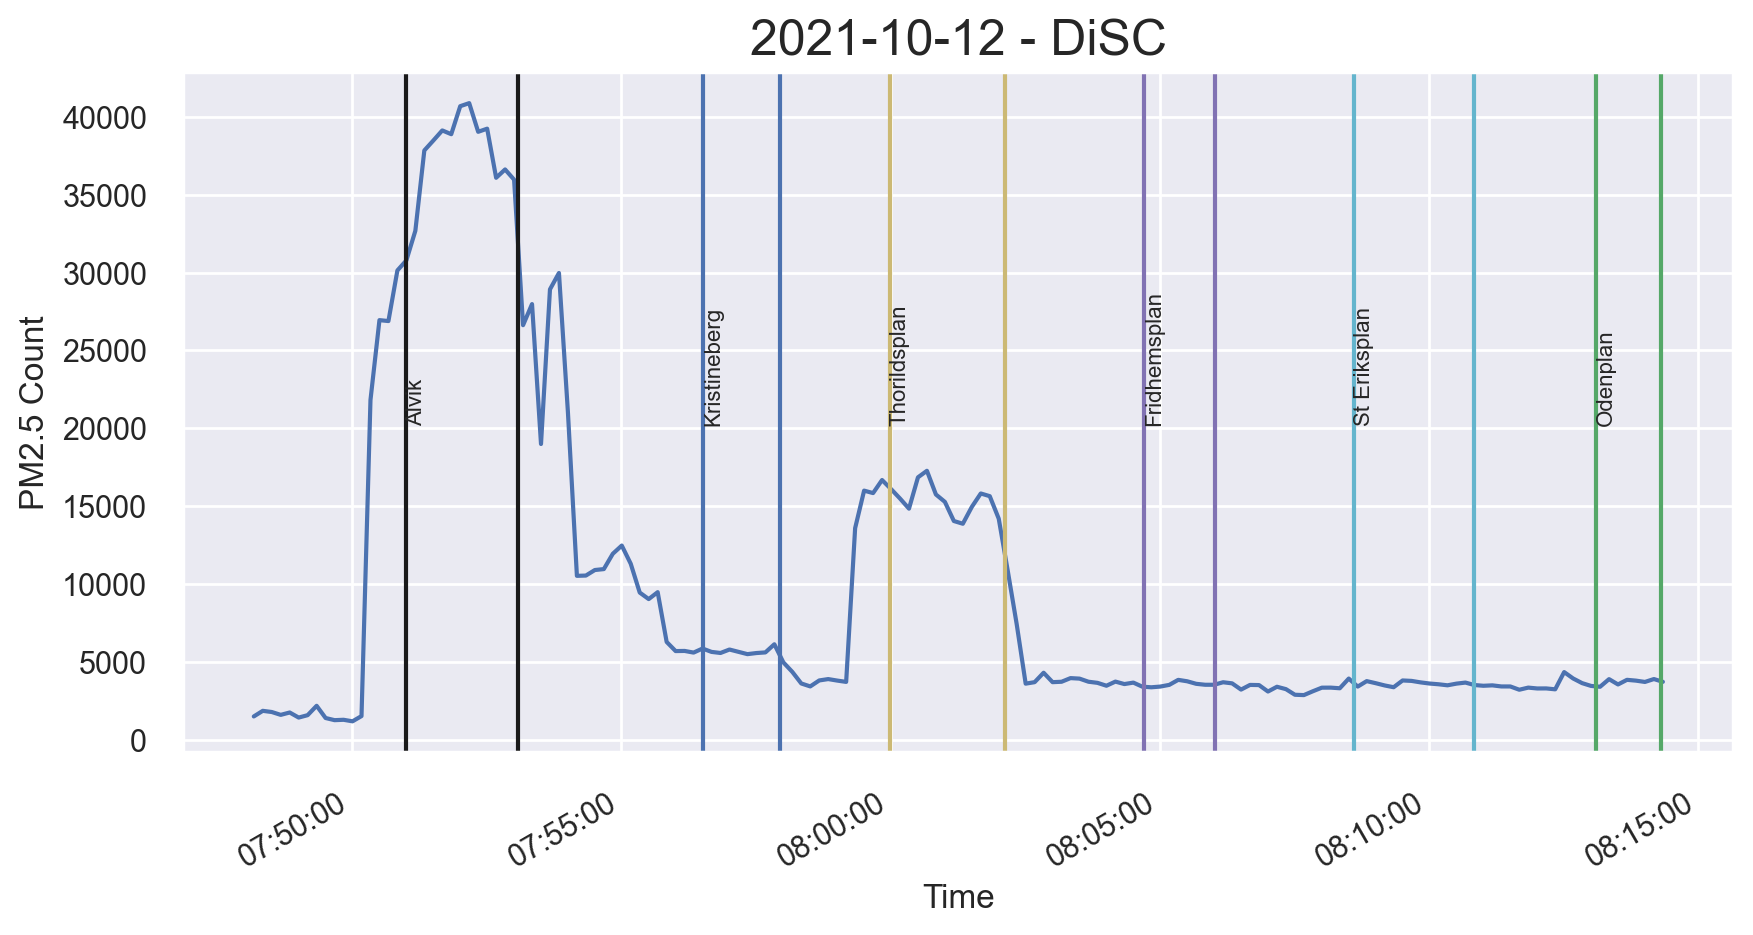

In [204]:
################################
# DONE 2021-10-12
################################

date = '2021-10-12'
period = 'AM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-2']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

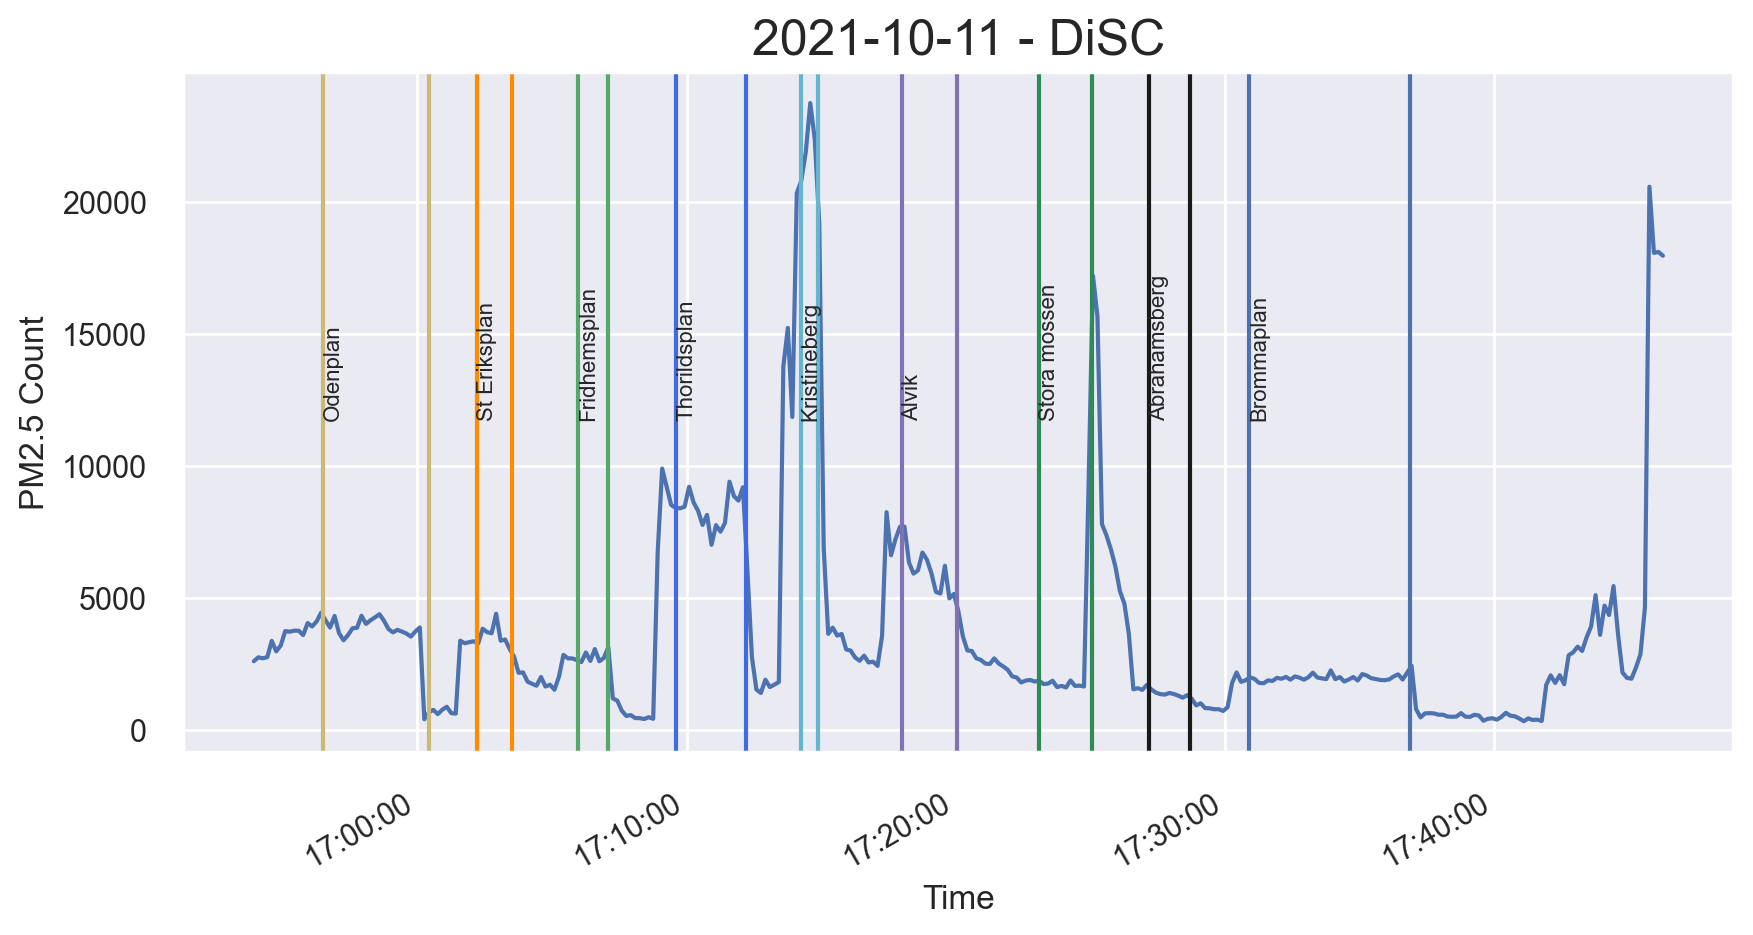

In [205]:
################################
# DONE 2021-10-11 PM
################################

date = '2021-10-11'
period = 'PM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-3']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

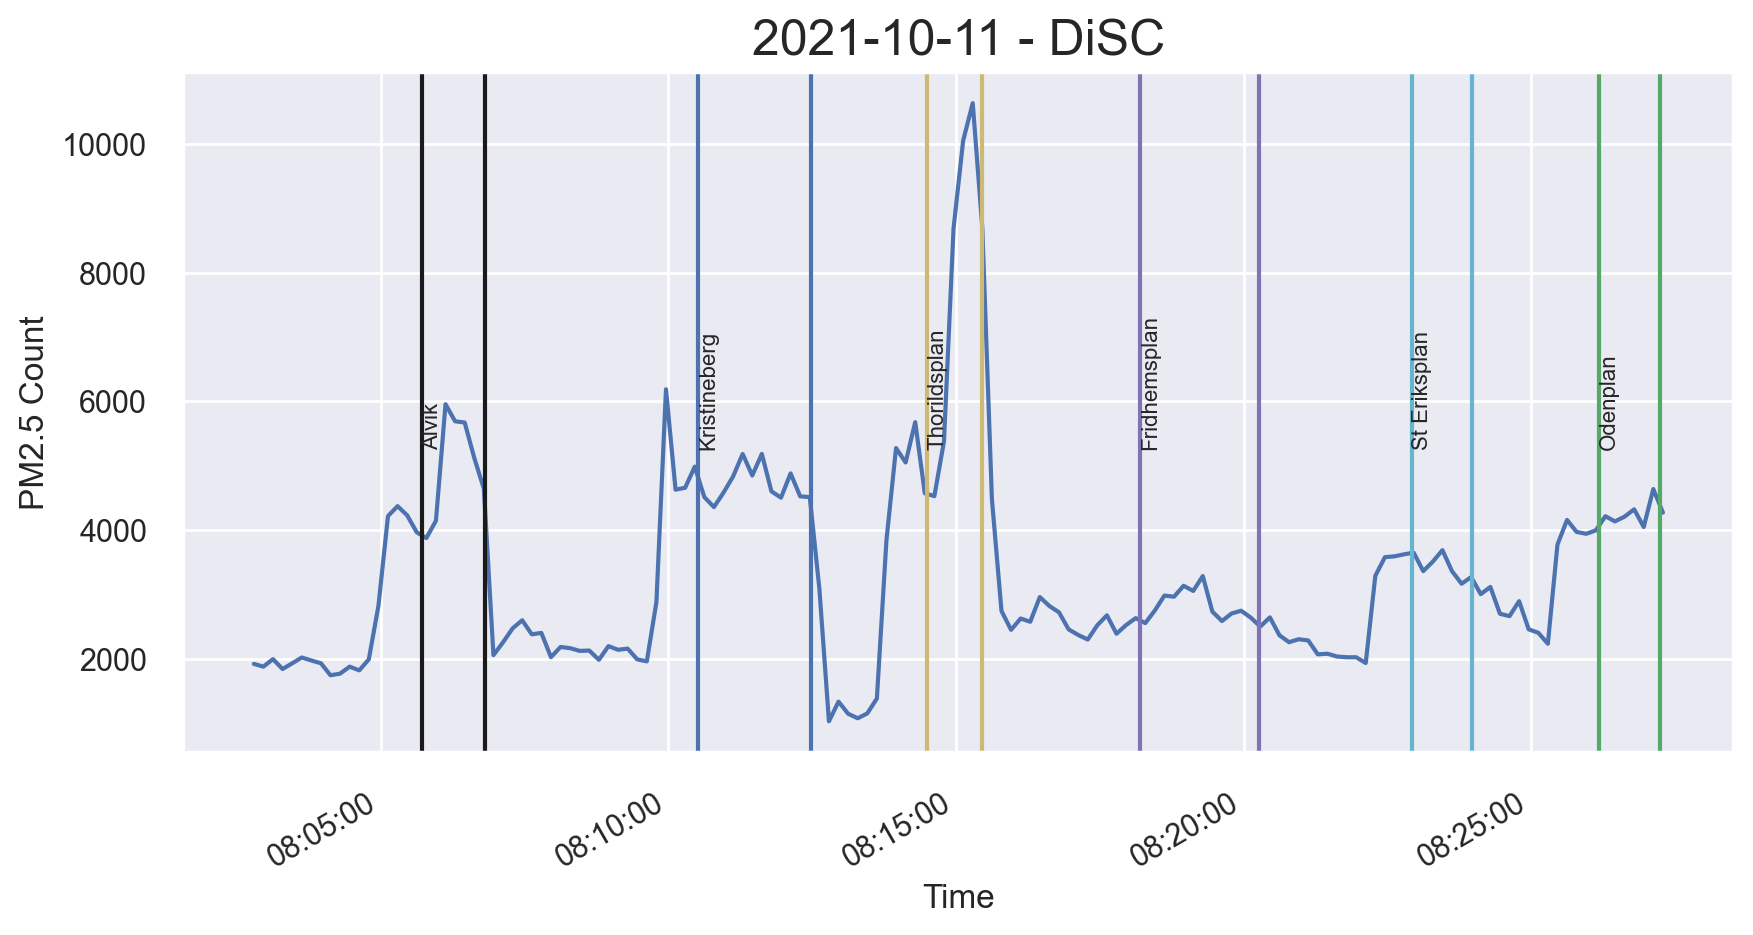

In [206]:
################################
# DONE 2021-10-11 AM
################################

date = '2021-10-11'
period = 'AM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-2']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

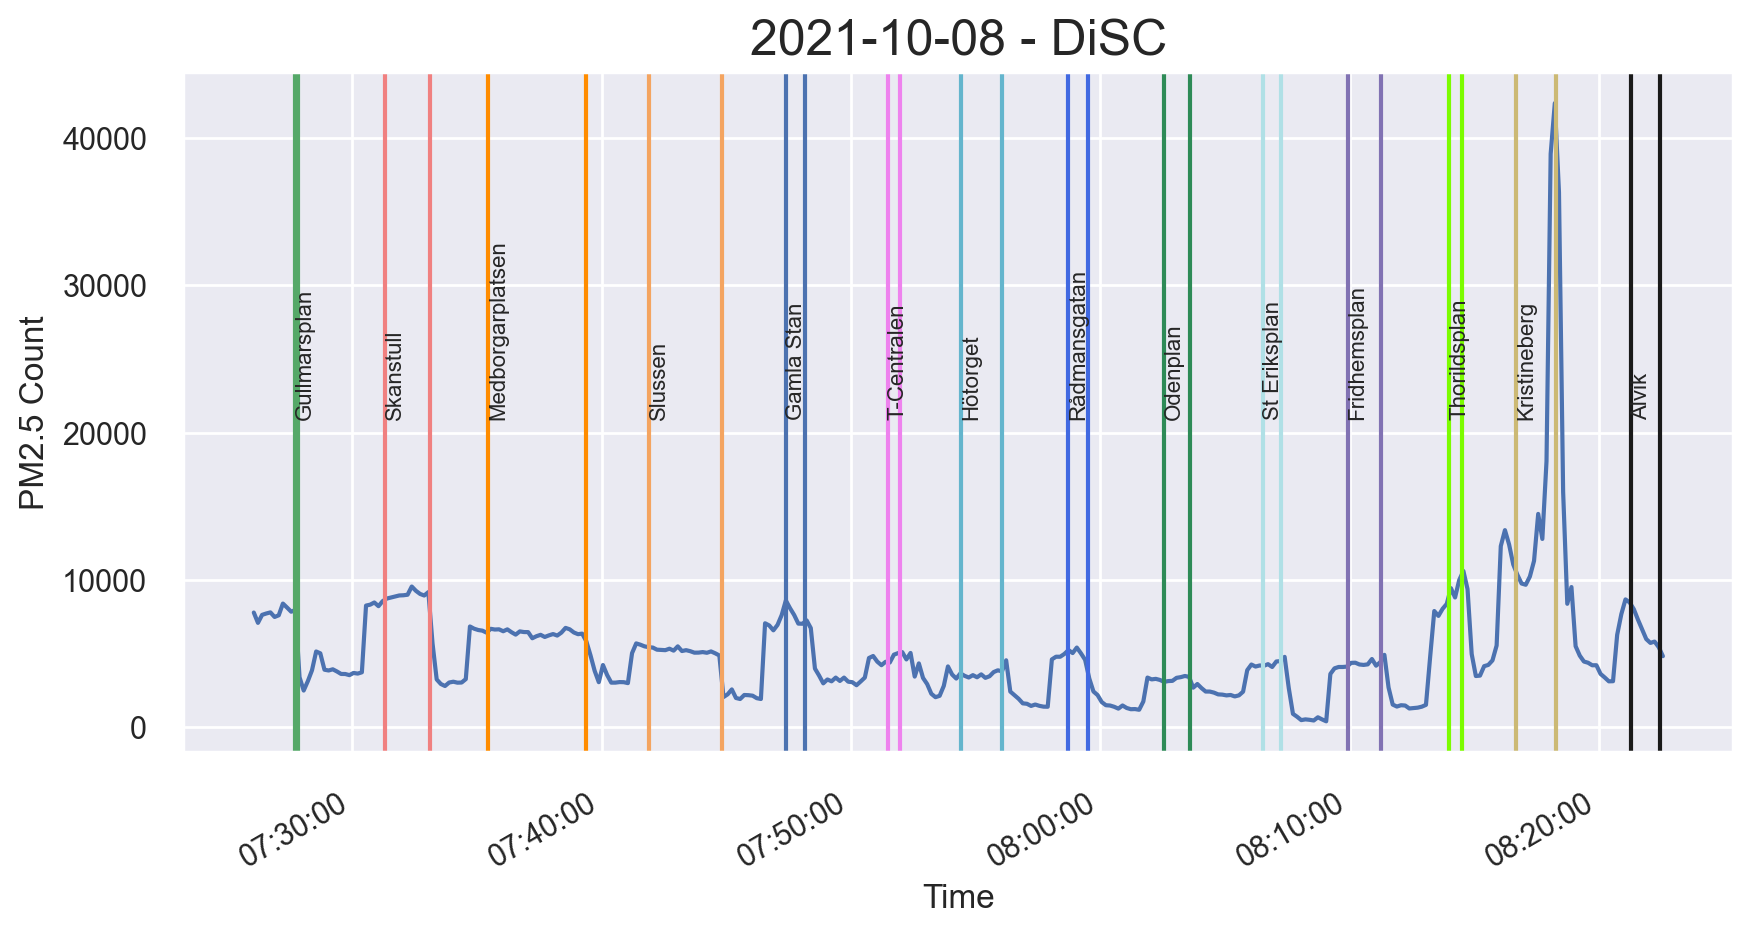

In [207]:
################################
# DONE 2021-10-08
################################

date = '2021-10-08'
period = 'AM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-1']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

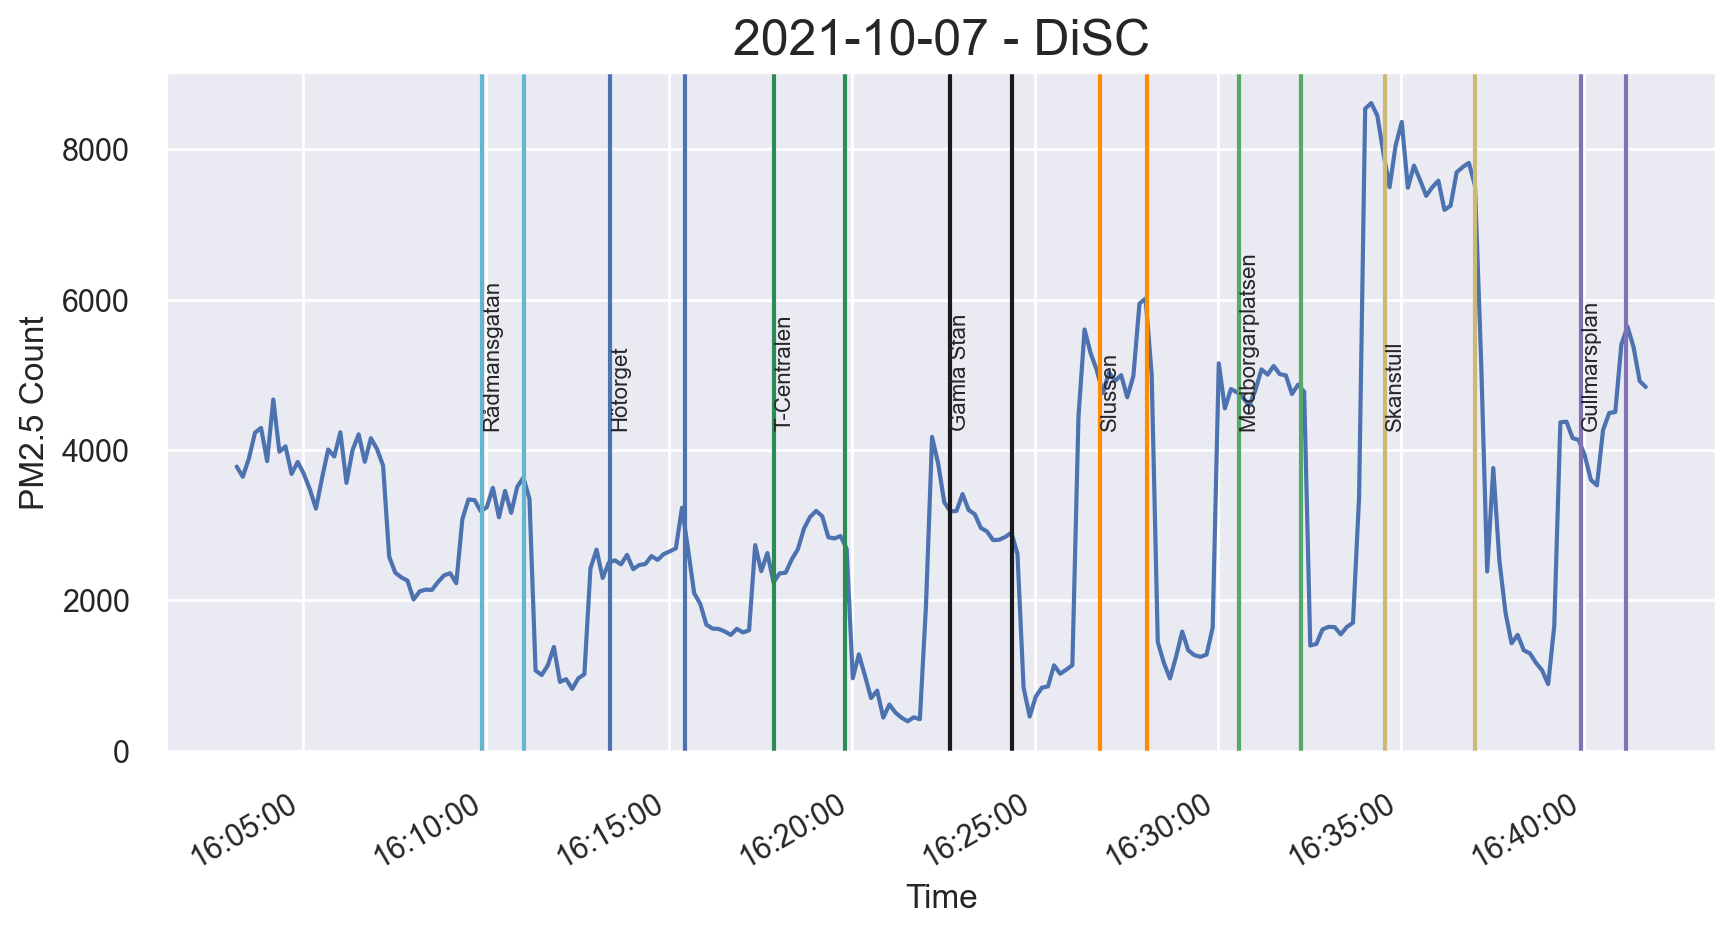

In [208]:
################################
# DONE 2021-10-07 PM
################################

date = '2021-10-07'
period = 'PM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-4']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)
disc_df = disc_df[disc_df['Timestamp'] < f'{date} 19:10:00']

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

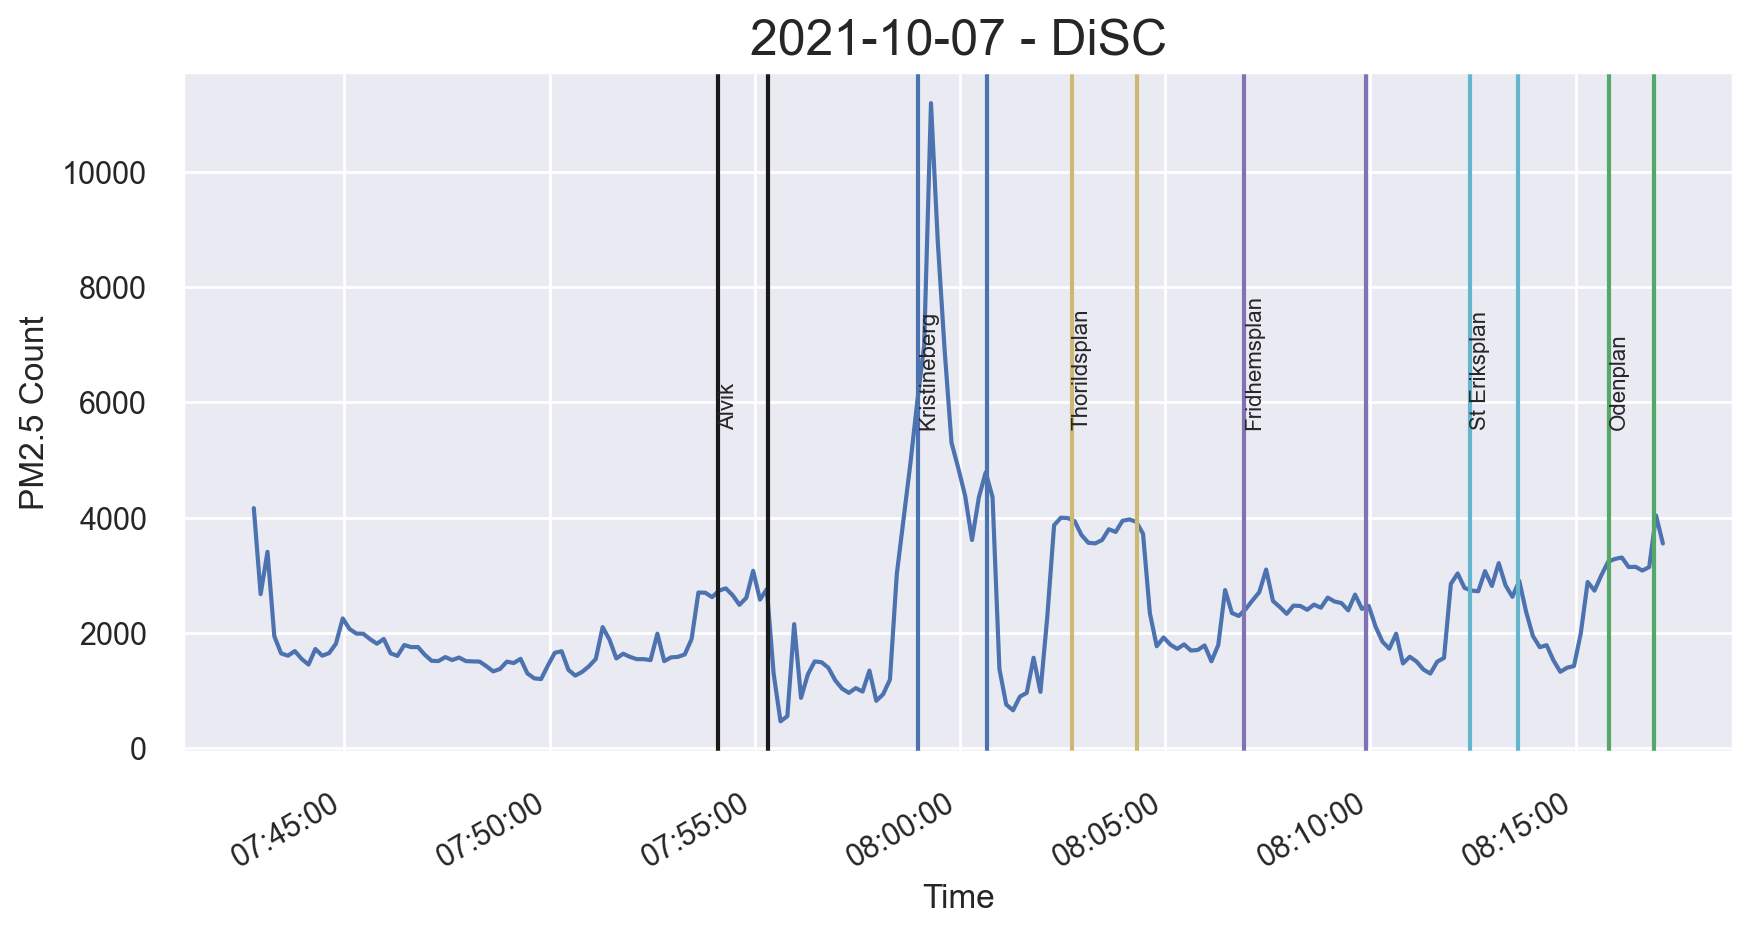

In [209]:
################################
# DONE 2021-10-07 AM
################################

date = '2021-10-07'
period = 'AM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-1']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)
disc_df = disc_df[disc_df['Timestamp'] < f'{date} 19:10:00']

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

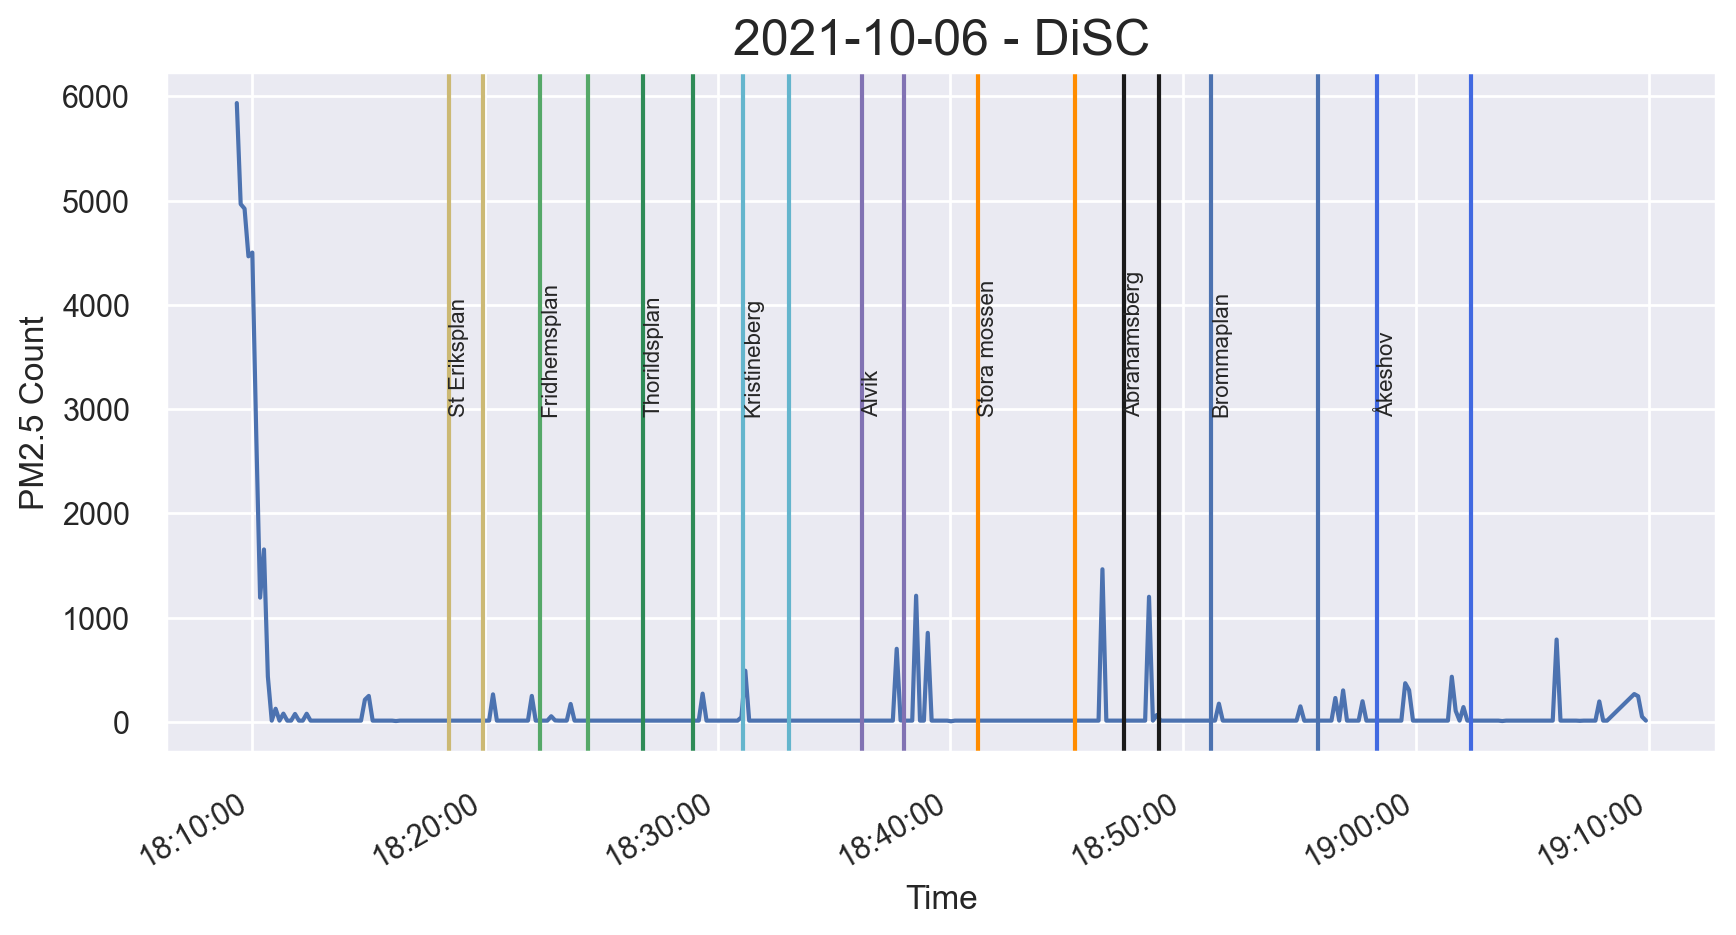

In [210]:
################################
# DONE 2021-10-06 PM
################################

date = '2021-10-06'
period = 'PM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-3']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)
disc_df = disc_df[disc_df['Timestamp'] < f'{date} 19:10:00']

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

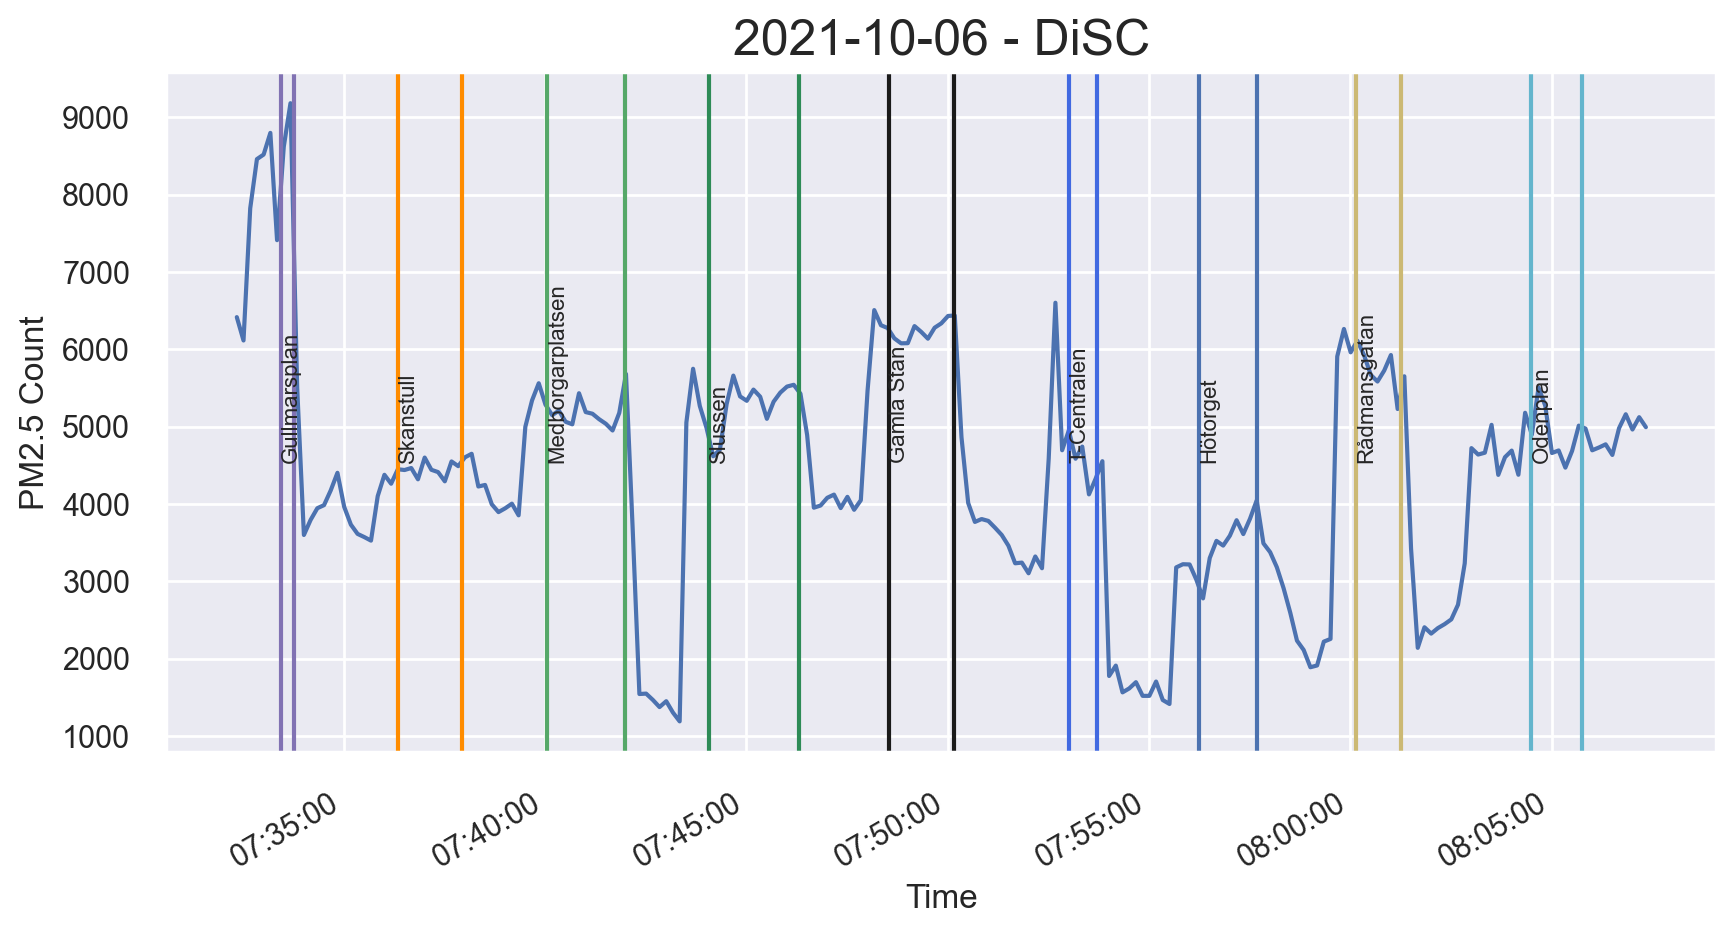

In [211]:
################################
# DONE 2021-10-06 AM
################################

date = '2021-10-06'
period = 'AM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-1']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)
disc_df = disc_df[disc_df['Timestamp'] < f'{date} 19:10:00']

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

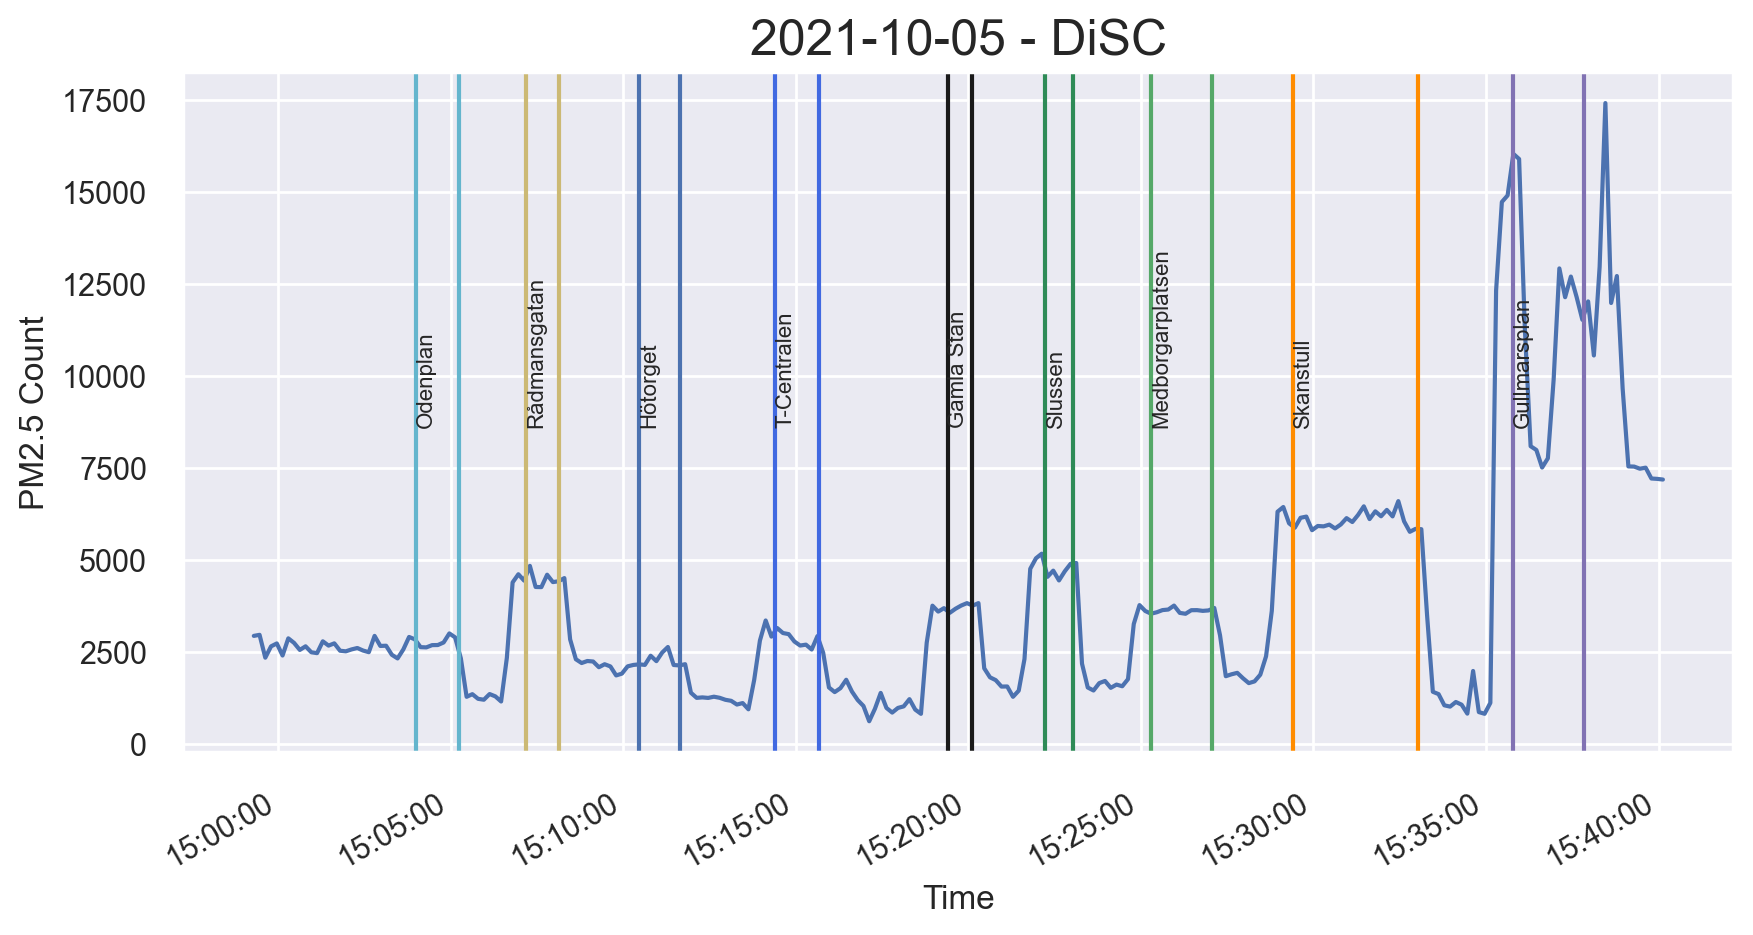

In [212]:
################################
# DONE 2021-10-05 PM
################################

date = '2021-10-05'
period = 'PM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-4']

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

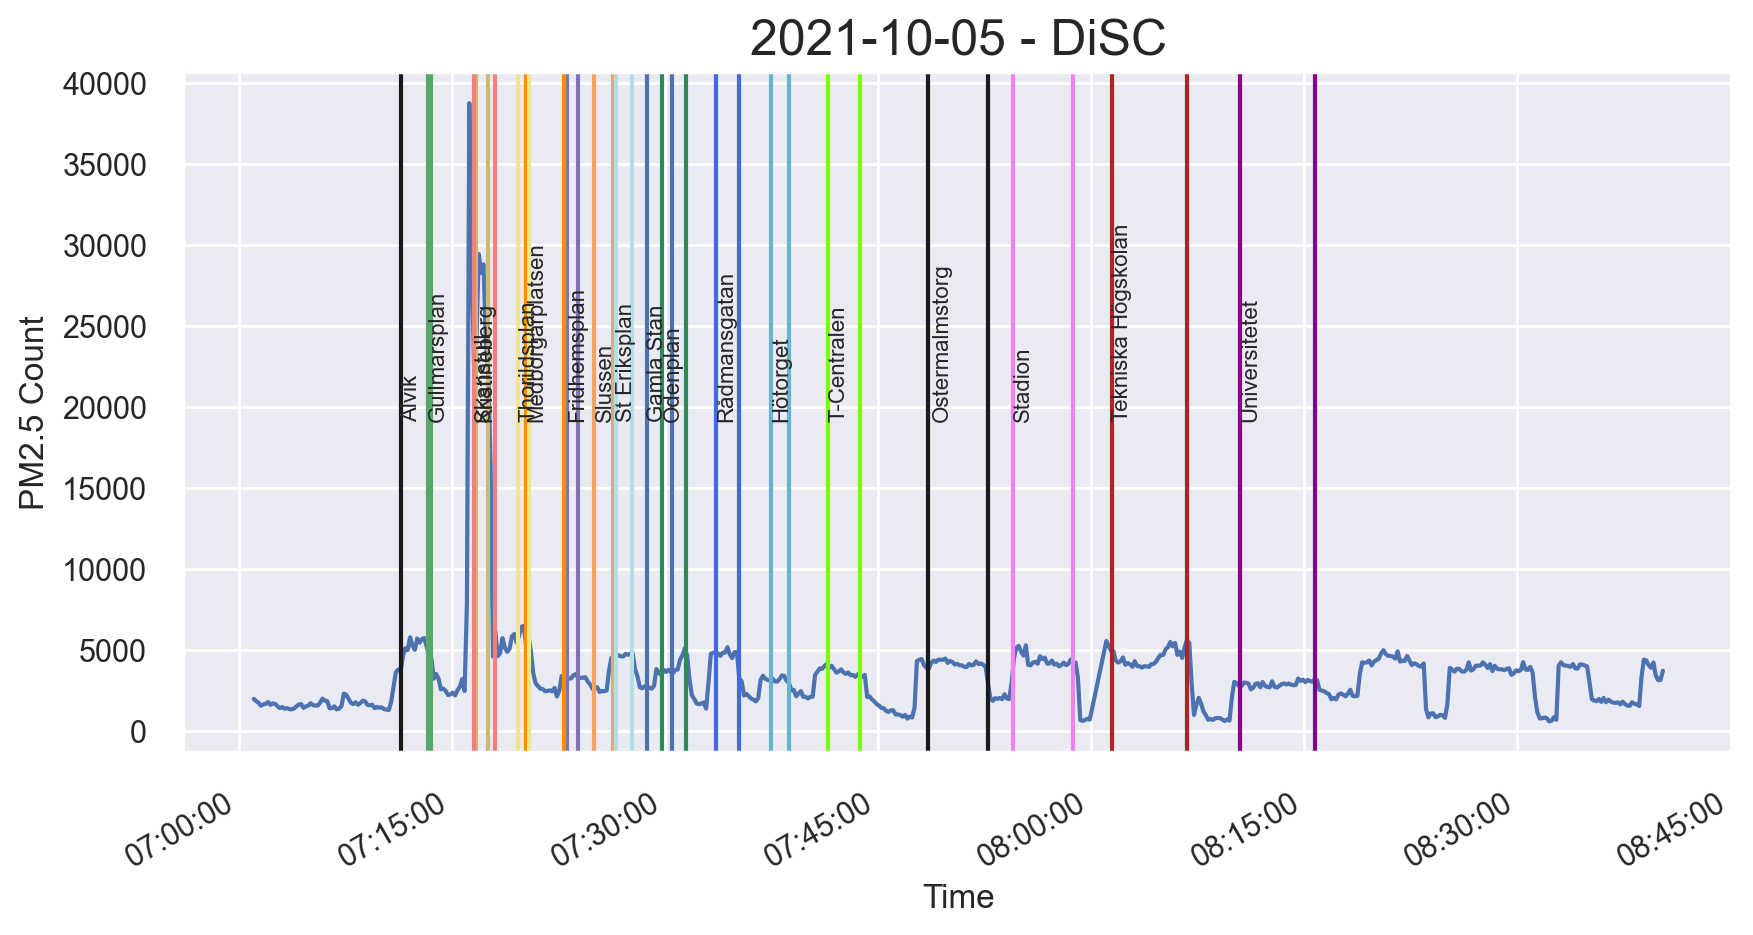

In [213]:
################################
# DONE 2021-10-05 AM
################################

date = '2021-10-05'
period = 'AM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session1 = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-1']
session2 = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-2']

session = pd.concat([session1, session2])

# Get raw session data
s_ids = list(session['Session Id'].unique())
s_data = r_df.loc[r_df['Session Id'].isin(s_ids)]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_ids[0], start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_ids[0]}-DiSC.csv')

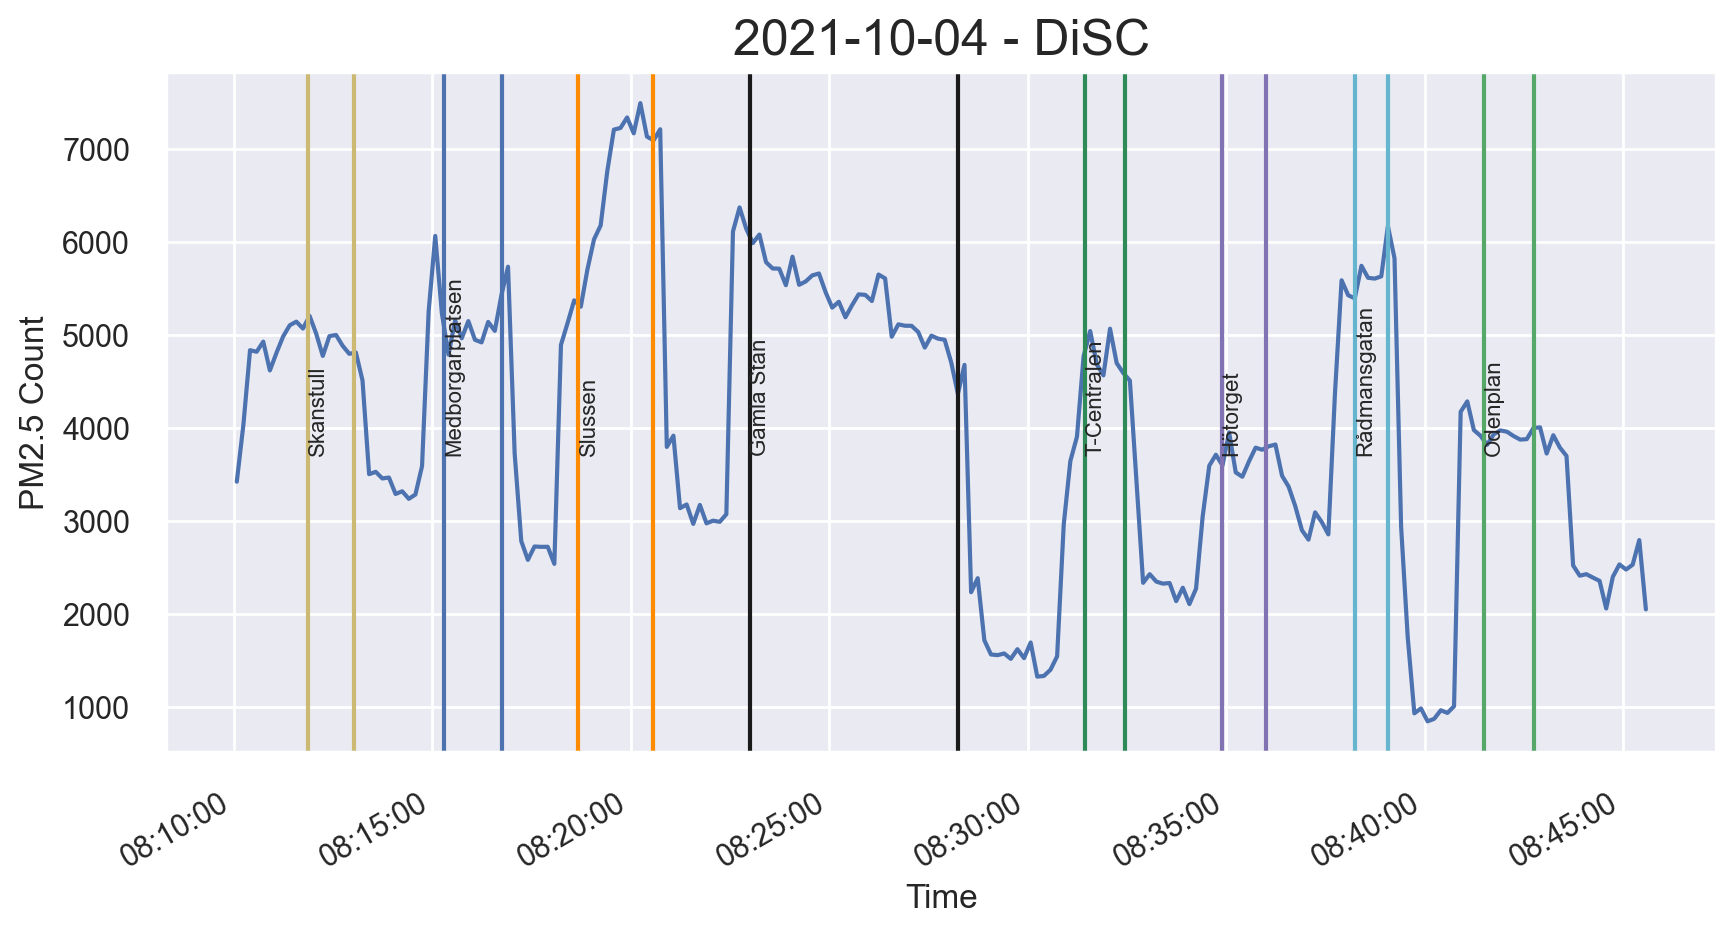

In [87]:
################################
# DONE 2021-10-04
################################

date = '2021-10-04'
period = 'AM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-1']

# Get raw session data
s_id = session['Session Id'].values[0]
s_data = r_df.loc[r_df['Session Id'] == s_id]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath, 70)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_id, start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_id}-DiSC.csv')

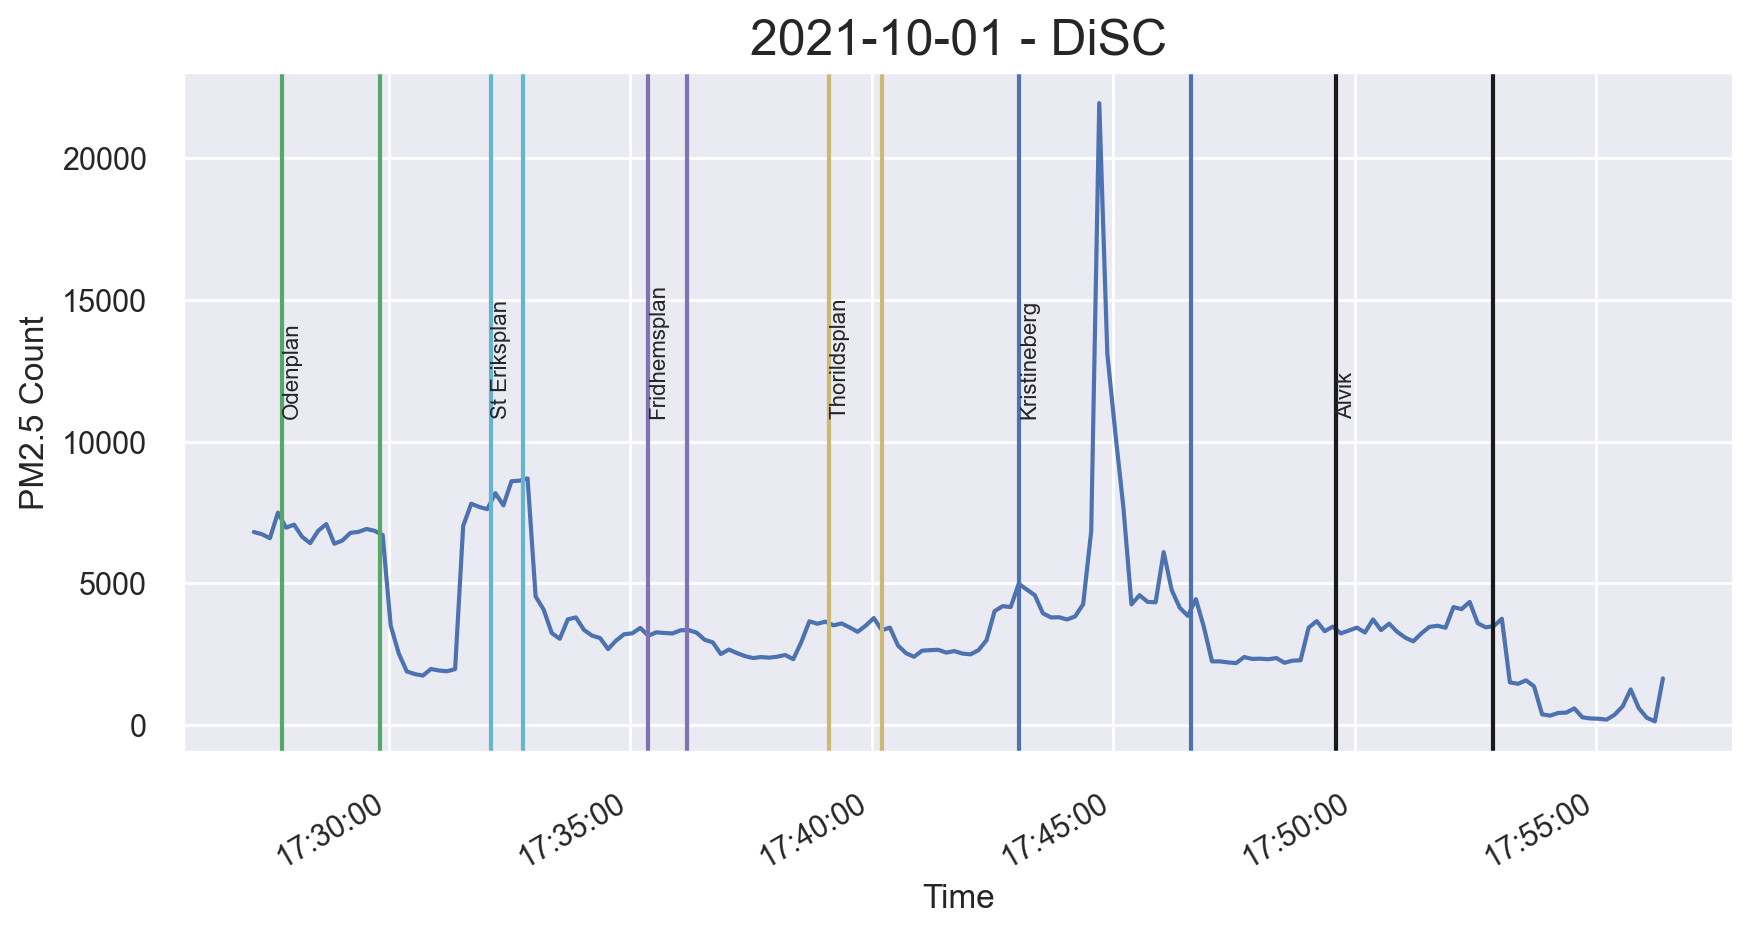

In [65]:
################################
# DONE 2021-10-01
################################

date = '2021-10-01'
period = 'PM'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-3']

# Get raw session data
s_id = session['Session Id'].values[0]
s_data = r_df.loc[r_df['Session Id'] == s_id]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_id, start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_id}-DiSC.csv')

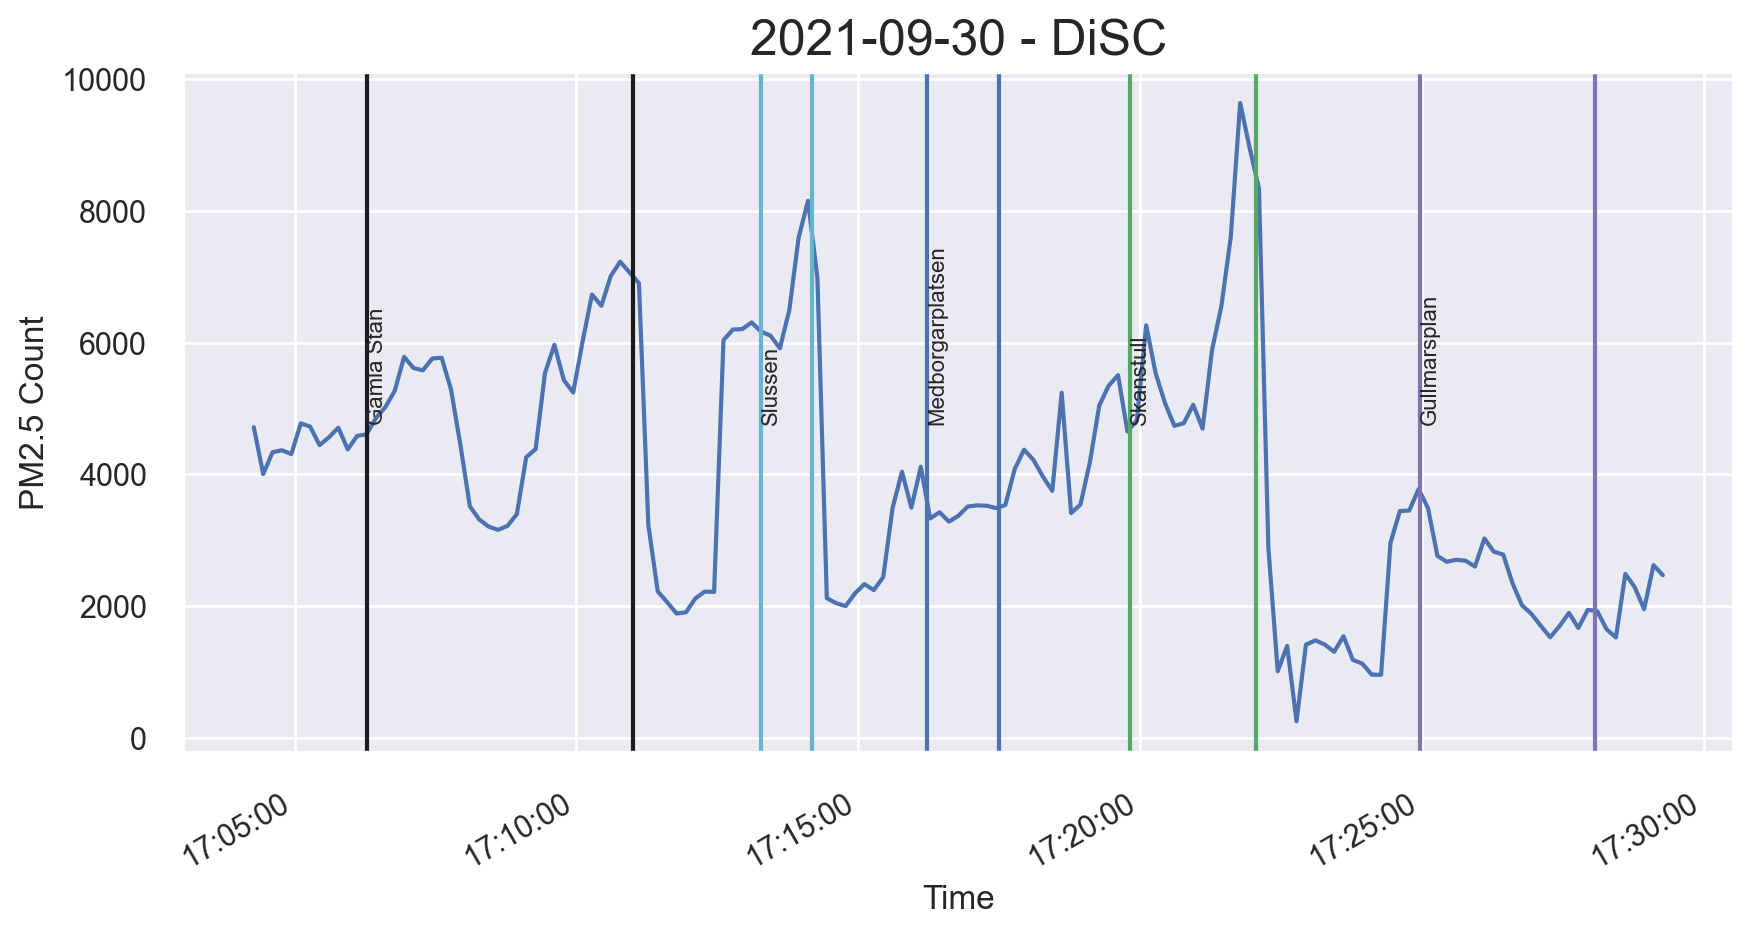

In [62]:
################################
# DONE 2021-09-30
################################

date = '2021-09-30'
period = 'PM2'

filepath = f'by-date-filtered/{date}/daniel-{period}.txt'
folder = f'sessionsDiSC/{date}'
fig_folder = folder + '/figures'

create_folders([folder, fig_folder])

# Get session
session = s_df.loc[s_df['Session Id'] == f'{date.replace("-", "")}-3']

# Get raw session data
s_id = session['Session Id'].values[0]
s_data = r_df.loc[r_df['Session Id'] == s_id]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath)

figname = f'{fig_folder}/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_id, start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_id}-DiSC.csv')

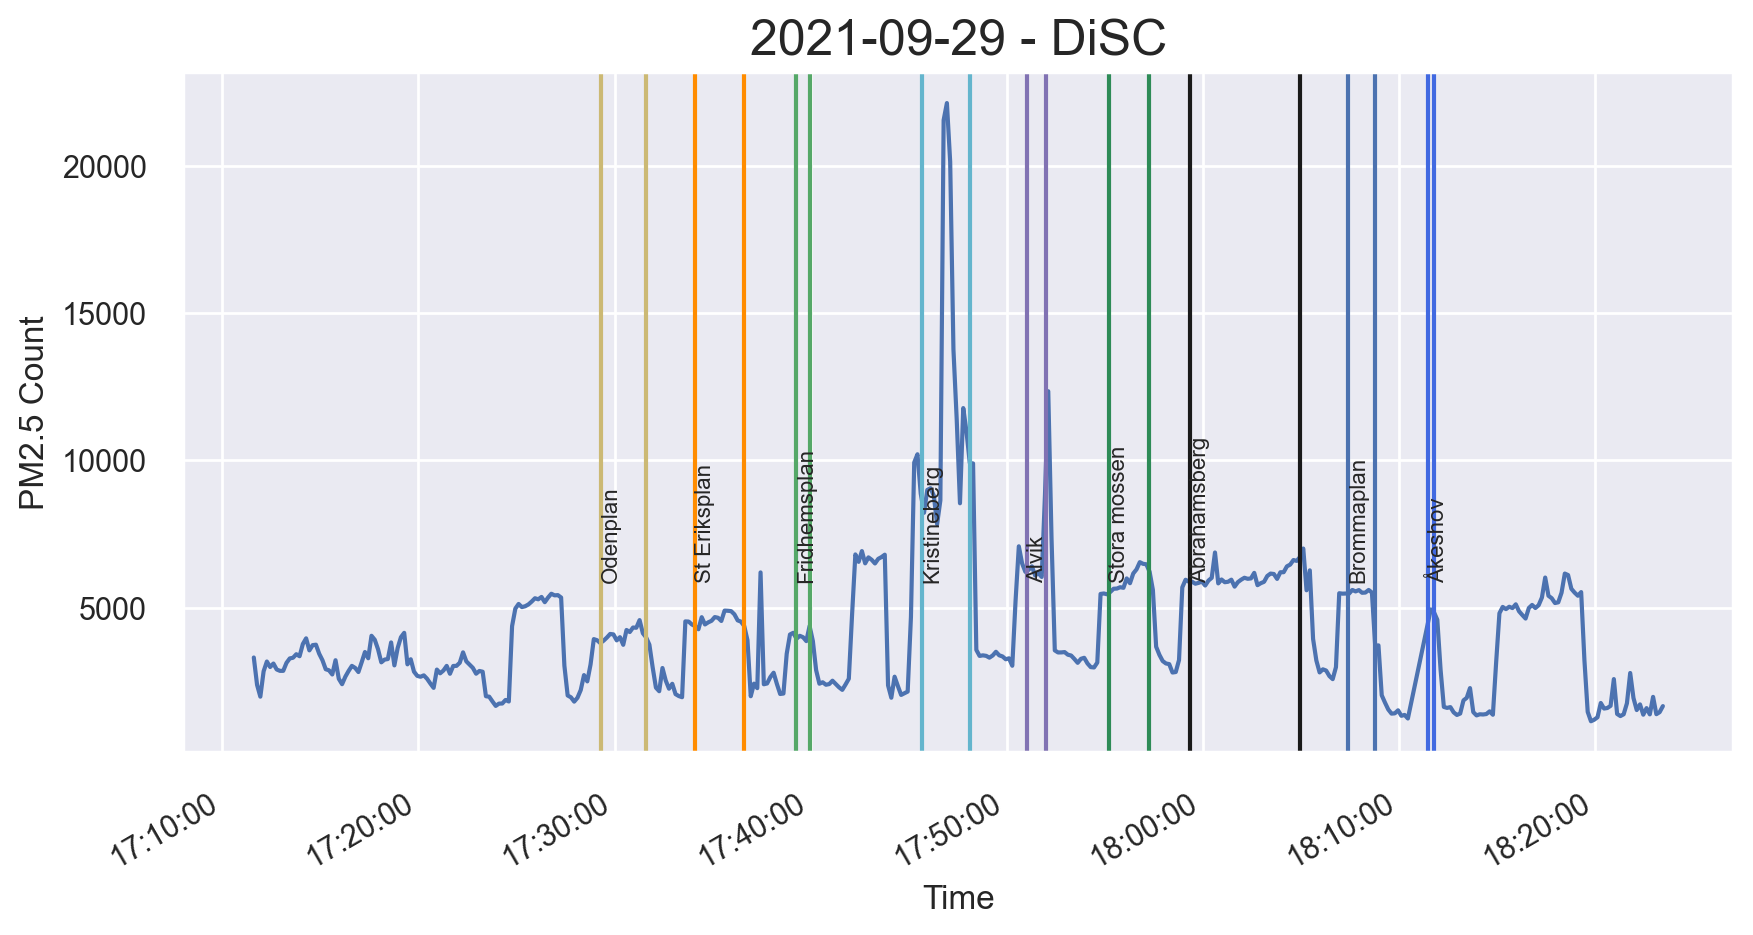

In [84]:
################################
# DONE 2021-09-29
################################

date = '2021-09-29'
period = 'PM'

folder = f'sessionsDiSC/{date}'
filepath = f'by-date-filtered/{date}/daniel-{period}.txt'

# Get session
if period == 'AM':
    session = s_df.loc[(s_df['Date'] == date) & (s_df['Timestamp'] <= f'{date} 12:00:00')]
    
if period == 'PM':
    session = s_df.loc[(s_df['Date'] == date) & (s_df['Timestamp'] >= f'{date} 12:00:00')]

# Get raw session data
s_id = session['Session Id'].values[0]
s_data = r_df.loc[r_df['Session Id'] == s_id]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath)

figname = folder + f'/_figures/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_id, start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_id}-DiSC.csv')

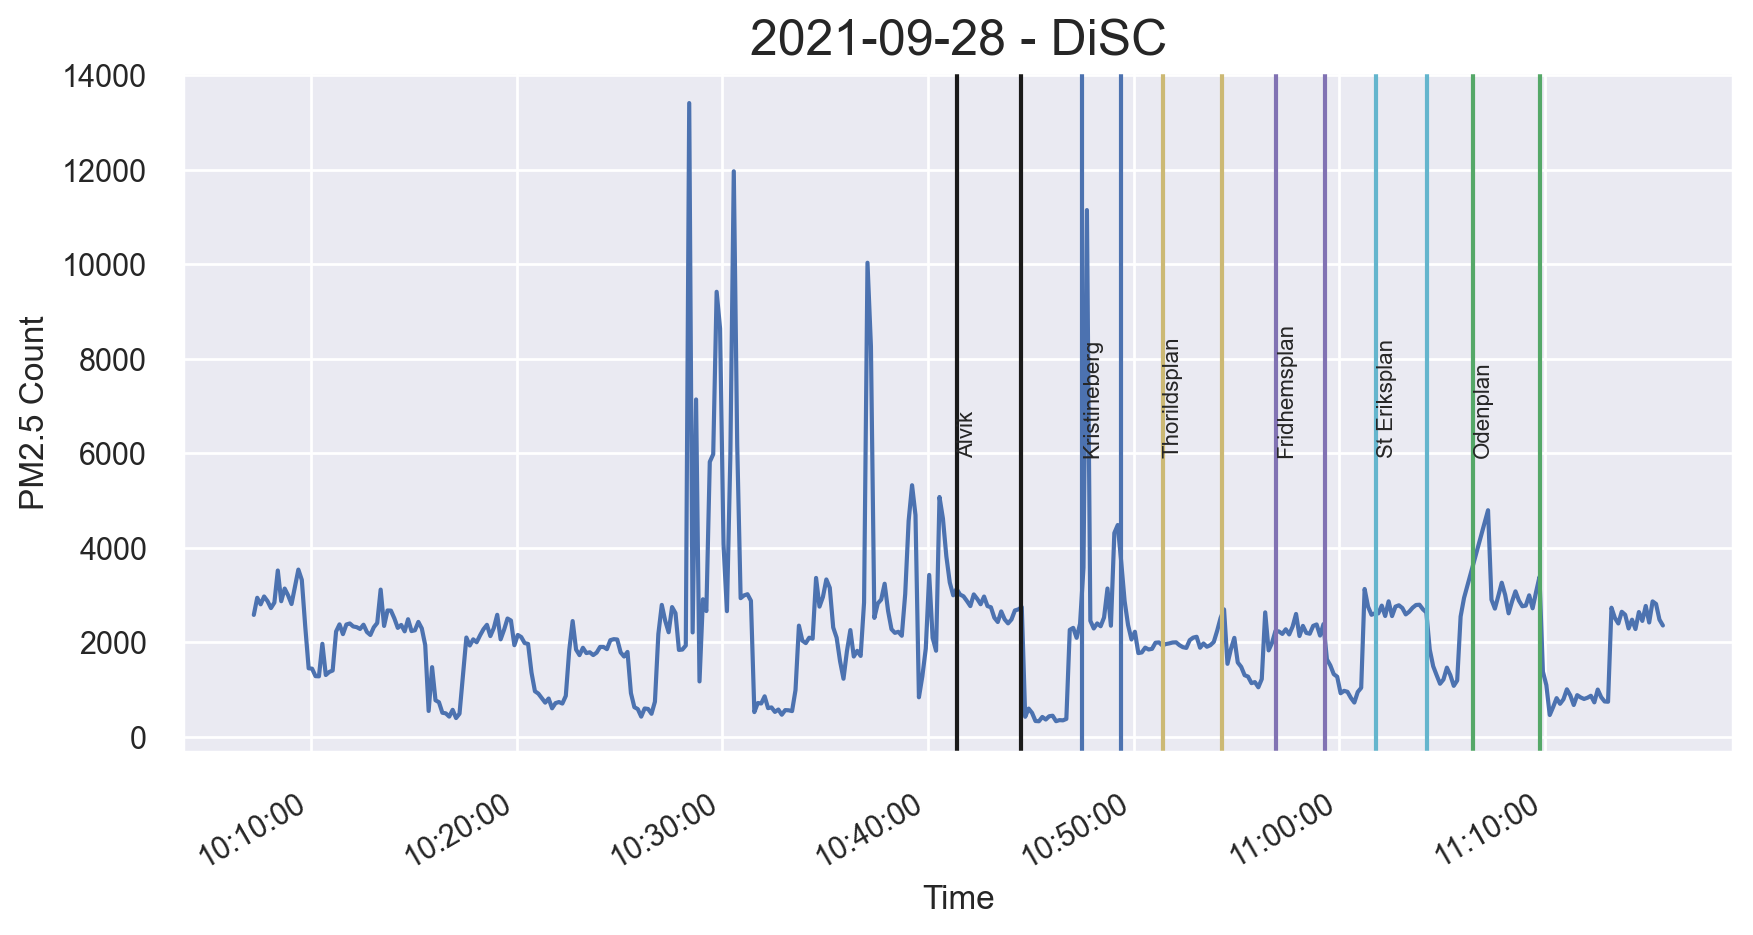

In [78]:
################################
# DONE 2021-09-28
################################

date = '2021-09-28'
folder = f'sessions_NC/{date}'

period = '2'

filepath = f'by-date-filtered/{date}/daniel-AM{period}.txt'

# Get session 
session = s_df.loc[(s_df['Date'] == date) & (s_df['Session Id'].str.endswith('1'))]

# Get raw session data
s_id = session['Session Id'].values[0]
s_data = r_df.loc[r_df['Session Id'] == s_id]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath)

figname = folder + f'/_figures/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_id, start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_id}-DiSC.csv')

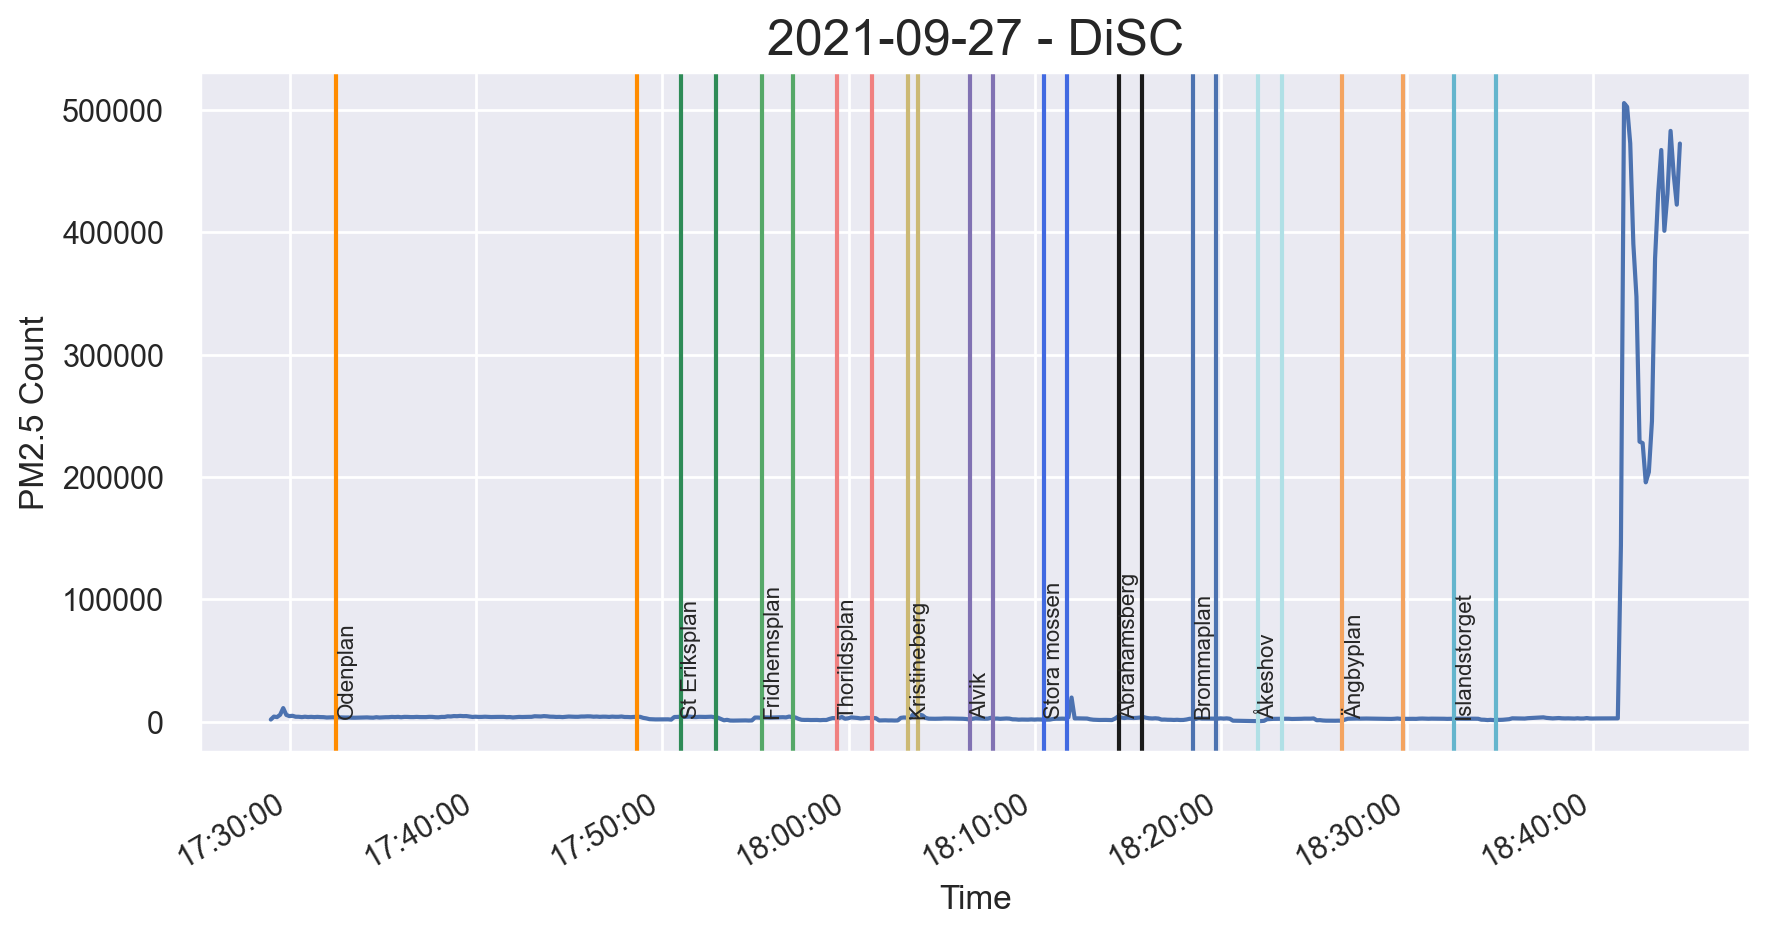

In [64]:
################################
# DONE 2021-09-27
################################

date = '2021-09-27'
period = 'PM'

folder = f'sessions_NC/{date}'
filepath = f'by-date-filtered/{date}/daniel-{period}.txt'

# Get session
if period == 'AM':
    session = s_df.loc[(s_df['Date'] == date) & (s_df['Timestamp'] <= f'{date} 12:00:00')]
    
if period == 'PM':
    session = s_df.loc[(s_df['Date'] == date) & (s_df['Timestamp'] >= f'{date} 12:00:00')]

# Get raw session data
s_id = session['Session Id'].values[0]
s_data = r_df.loc[r_df['Session Id'] == s_id]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath)

figname = folder + f'/_figures/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_id, start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_id}-DiSC.csv')

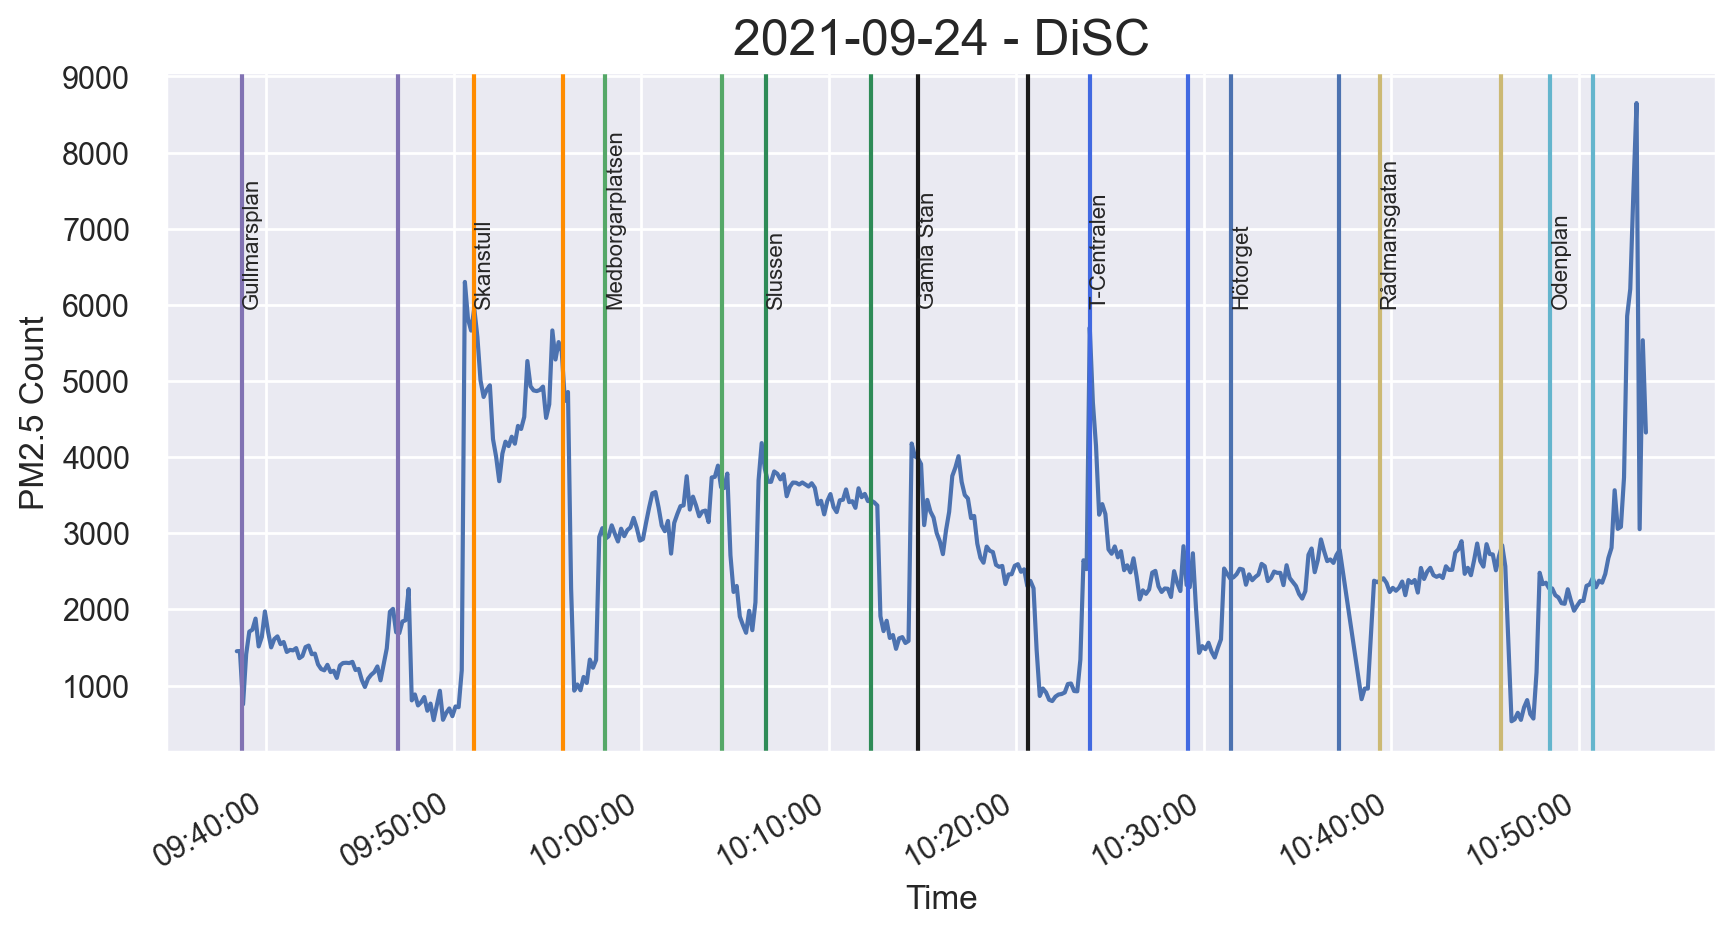

In [61]:
################################
# DONE 2021-09-24
################################

date = '2021-09-24'
period = 'AM'

folder = f'sessions_NC/{date}'
filepath = f'by-date-filtered/{date}/daniel-{period}.txt'

# Get session
if period == 'AM':
    session = s_df.loc[(s_df['Date'] == date) & (s_df['Timestamp'] <= f'{date} 12:00:00')]
    
if period == 'PM':
    session = s_df.loc[(s_df['Date'] == date) & (s_df['Timestamp'] >= f'{date} 12:00:00')]

# Get raw session data
s_id = session['Session Id'].values[0]
s_data = r_df.loc[r_df['Session Id'] == s_id]

# Get start and stop for stations
start_stop = s_data.groupby('Station').agg({'Timestamp': ['min', 'max']})
disc_df = get_disc_df(date, filepath)

figname = folder + f'/_figures/{s_id}-DiSC.pdf'
title = f'{date} - DiSC'

# Plot
plot_disc(disc_df, start_stop, title, figname)

# Save to csv
session_chunk = get_disc_chunk(s_id, start_stop, disc_df)
session_chunk.to_csv(f'{folder}/{s_id}-DiSC.csv')